<a href="https://colab.research.google.com/github/leobioinf0/Machine-Learning-Advanced/blob/main/S12_T01_Pipelines_grid_search_text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IT Academy - Data Science with Python
## [Sprint 12. Machine learning avançat](https://github.com/jesussantana/Supervised-Regression/blob/main/notebooks/S12_T01_Supevised_Regression.ipynb) 
### [S12 T01: Pipelines, grid search i text mining](https://github.com/jesussantana/Supervised-Regression) 



#### Exercises: 

We are starting to get acquainted with Pipelines, grid search and text mining. Let’s start with a few basic exercises.

- Level 1
    - Exercise 1: 
        - Use the data set you want and do a pipeline and a gridsearch using the Random Forest algorithm.
    - Exercise 2: 
        - Use a text in English that you want and calculate the frequency of the words
- Level 2
    - Exercise 3: 
        - Remove stopwords and stemming your dataset.

- Level 3
    - Exercise 4: 
        - Perform sentiment analysis on your dataset.

Resources
Classroom resources and https://www.nltk.org

# Setup

## Upgrade modules

In [214]:
# !pip3 install --upgrade matplotlib
# !pip3 install --upgrade scikit-learn
# !pip3 install --upgrade numpy
# !pip3 install --upgrade pandas
# !pip3 install --upgrade seaborn
# !pip3 install --upgrade nltk
# !pip3 install --upgrade bs4
# !pip3 install --upgrade wordcloud

## Importing Dependencies

In [215]:

import requests
import os
import math
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(130)
sns.set(style='whitegrid', palette='Set2', font_scale=1.2)
sns.set(rc={'figure.figsize':(12,7)})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Define functions

In [216]:
def rounder(n):
    """
    Round up to the first digit that is not zero
    """
    if n == 0:
        return n
    else:
        k = 1 - int(math.log10(n))
        return round(n, 1 if n > 1 else k)

def describer(dataframe):
    """
    Description of dataframe
    """
    desc_df = round(dataframe.describe(include="all"),2).T
    desc_df["unique"]=dataframe.nunique()
    desc_df["NullAny"]= dataframe.isnull().any()
    desc_df["NullSum"]=dataframe.isnull().sum()
    desc_df["NullPct"]=(dataframe.isnull().sum()/len(dataframe)*100).apply(rounder)
    desc_df["dtypes"]=dataframe.dtypes
    desc_df["dtypes"] = desc_df["dtypes"].astype('category')
    desc_df.sort_values(by="dtypes", inplace=True)
    return(desc_df)

def impute_age(input_df):
    """
    Imputes the average age according to the title to which it belongs.
    """
    titles = ['Mrs. ','Ms. ','Miss. ','Mr. ','Master. ','Dr. ']
    for title in titles: 
        title_mean_age = round(input_df[(input_df.name.str.contains(title))]['age'].mean())
        input_df.loc[input_df.name.str.contains(title),'age'] = input_df.loc[input_df.name.str.contains(title),'age'].fillna(value=title_mean_age)
    
    input_df.age = np.ceil(input_df.age)
    return input_df
    
def impute_fare(input_df):
    """
    Imputes the mode fare according to the 'pclass' and 'embarked' group to which it belongs.
    """
    for i in input_df.loc[input_df.fare.isnull()].index:
        input_df.loc[i,"fare"] = input_df.loc[(input_df.pclass==input_df.iloc[i].pclass)&
                                              (input_df.embarked==input_df.iloc[i].embarked),"fare"].mode()[0]
    return input_df

def impute_embarked(input_df):
    """
    Imputes the embarked mode according to the 'pclass' and 'cabin' group to which it belongs.
    """
    for i in input_df.loc[input_df.embarked.isnull()].index:
        input_df.loc[i,"embarked"] = input_df.loc[(input_df.pclass==input_df.iloc[i].pclass)&
                                                  (input_df.cabin.str.match(input_df.iloc[i].cabin[:-1])),"embarked"].mode()[0]
    input_df.embarked = input_df.embarked.astype("category").cat.codes
    return input_df

def process_cabin(input_df):
    """
    Removes the number of the cabin keeping only the letter.
    """
    input_df['cabin'] = pd.Series([i if pd.isnull(i) else i[0] for i in input_df['cabin']])
    return input_df

def process_sex(input_df):
    """
    Convert sex to binary numerical category. female = 0, male = 1
    """
    input_df.sex = input_df.sex.astype("category").cat.codes
    return input_df

def process_pclass(input_df):
    """
    Convert pclass to numerical category. 1 = 0, 2 = 1, 3 = 2
    """
    input_df.pclass = input_df.pclass.astype("category").cat.codes
    return input_df

def impute_cabin(input_df):
    """
    Imputes the cabin mode according to the 'fare', 'pclass' and 'embarked' group to which it belongs.
    """
    i = 0
    while input_df.cabin.isnull().any():
        nulls_indexes = input_df[input_df.cabin.isnull()].index
        for index in nulls_indexes:
            e,p,f = input_df.loc[index,["embarked","pclass", "fare"]].values
            cabin_mode = input_df.loc[(input_df.embarked==e)&(input_df.pclass==p)&((input_df.fare>=f-i)& (input_df.fare<=f+i)),"cabin"].mode().tolist()
            if len(cabin_mode) > 0:
                input_df.loc[index] = input_df.loc[index].fillna(value=cabin_mode[0])
        i=i+1
    input_df.cabin = input_df.cabin.astype("category").cat.codes
    return input_df


def paragraph_to_words(paragraph):
    """
    Remove non-letters characters, convert to lowercase and 
    perform word tokenizer to a paragraph. 
    """
    cln_paragraph=re.sub('[^a-zA-Z]'," ", paragraph) 
    words = word_tokenize(cln_paragraph.lower())
    return words

def remove_stopwords(words):
    """
    Remove stopwords from a list of words. 
    """
    stop=stopwords.words('english')
    stop.extend(['laughter', 'applause', 'from'])
    stop=(stop)
    cln_words=[w for w in words if not w in stop]
    return cln_words

def words_to_stem(words):
    """
    Obtein stem words from a list of words. 
    """
    stemmer=nltk.PorterStemmer()
    stem_words=[stemmer.stem(w) for w in words]
    return stem_words

## Define classes

In [217]:
class DropColumnsTransformer():
    '''
    Custom transformer that drops the column/s that is 
    passed as an argument to the data to be transformed
    '''
    def __init__(self, columns=None):
        self.columns = list(columns)

    def transform(self, X, **transform_params):
        cpy_df = X.drop(self.columns, axis=1).copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self


class ColumnsTransformer():
    '''
    Custom transformer that applies the function that is 
    passed as an argument to the data to be transformed
    '''
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# Exercise 1:
Use the data set you want and do a pipeline and a gridsearch using the Random Forest algorithm.

## Loading the Data

The titanic dataset contains the following information on passengers of the titanic:

- **Survival**: Survival 0 = No, 1 = Yes (Prediction Label)
- **Pclass**: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- **Sex**: Sex
- **Age**: Age in years
- **SibSp**: # of siblings / spouses aboard the Titanic
- **Parch**: # of parents / children aboard the Titanic
- **Ticket**: Ticket number
- **Fare**: Passenger fare
- **Cabin**: Cabin number
- **Embarked**: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [218]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [219]:
X.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [220]:
describer(X)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,NullAny,NullSum,NullPct,dtypes
pclass,1309.0,3,NaN,NaN,2.29,0.84,1.0,2.0,3.0,3.0,3.0,False,0,0.00,float64
age,1046.0,98,NaN,NaN,29.88,14.41,0.17,21.0,28.0,39.0,80.0,True,263,20.10,float64
sibsp,1309.0,7,NaN,NaN,0.5,1.04,0.0,0.0,0.0,1.0,8.0,False,0,0.00,float64
parch,1309.0,8,NaN,NaN,0.39,0.87,0.0,0.0,0.0,0.0,9.0,False,0,0.00,float64
fare,1308.0,281,NaN,NaN,33.3,51.76,0.0,7.9,14.45,31.28,512.33,True,1,0.08,float64
body,121.0,121,NaN,NaN,160.81,97.7,1.0,72.0,155.0,256.0,328.0,True,1188,90.80,float64
name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0.00,object
ticket,1309,929,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0.00,object
cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1014,77.50,object
boat,486,27,13,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,823,62.90,object


## Imputation pipelline

The following steps are performed in the pipeline:
1. Delete the columns "sibsp","parch","boat","body","home.dest","ticket"
2. Impute the missing ages based on the information extracted from the name
3. Delete column name
4. Impute fare and embarked
5. Transform pclass and sex to numerical category.
6. Transform cabin by removing the number and keeping only the letter.
7. Impute cabin.

In [221]:
imputer = Pipeline([('drop_columns', DropColumnsTransformer(["sibsp","parch","boat","body","home.dest","ticket"])),
                     ("impute_age", ColumnsTransformer(impute_age)),
                     ('drop_name', DropColumnsTransformer(["name"])),
                     ("impute_fare", ColumnsTransformer(impute_fare)),
                     ("impute_embarked", ColumnsTransformer(impute_embarked)),
                    ("process_sex", ColumnsTransformer(process_sex)),
                    ("process_pclass", ColumnsTransformer(process_pclass)),
                     ("process_cabin", ColumnsTransformer(process_cabin)),
                     ("impute_cabin", ColumnsTransformer(impute_cabin))])

In [222]:
X = imputer.fit_transform(X)

In [223]:
X.head()

,pclass,sex,age,fare,cabin,embarked
0,0,0,29.0,211.3375,1,2
1,0,1,1.0,151.5500,2,2
2,0,0,2.0,151.5500,2,2
3,0,1,30.0,151.5500,2,2
4,0,0,25.0,151.5500,2,2


In [224]:
describer(X)

,count,mean,std,min,25%,50%,75%,max,unique,NullAny,NullSum,NullPct,dtypes
pclass,1309.0,1.29,0.84,0.0,1.0,2.00,2.00,2.00,3,False,0,0.0,int8
sex,1309.0,0.64,0.48,0.0,0.0,1.00,1.00,1.00,2,False,0,0.0,int8
cabin,1309.0,4.07,1.50,0.0,4.0,4.00,5.00,7.00,8,False,0,0.0,int8
embarked,1309.0,1.49,0.81,0.0,1.0,2.00,2.00,2.00,3,False,0,0.0,int8
age,1309.0,29.88,13.18,1.0,22.0,30.00,36.00,80.00,72,False,0,0.0,float64
fare,1309.0,33.28,51.74,0.0,7.9,14.45,31.28,512.33,281,False,0,0.0,float64


## Transforming pipelline

The following steps are performed in the pipeline:
1. Scale the numeric data ('age', 'fare') by applying the RobustScaler
2. Encode the categorical data ('pclass', 'sex', 'embarked', 'cabin') by applying the OneHotEncoder

In [225]:
cat_transformer = Pipeline([('onehot', OneHotEncoder())])
num_transformer = Pipeline([('robustscaler', RobustScaler())])

In [226]:
transformer = ColumnTransformer([('num', num_transformer, ['age', 'fare']),
                                 ('cat', cat_transformer, ['pclass','sex','embarked','cabin'])])

In [227]:
X = transformer.fit_transform(X)

When transformed, the data is in matrix format. In the next step we table them in a dataframe.

In [228]:
X = pd.DataFrame(X, columns=transformer.get_feature_names_out()).rename(columns=lambda x: re.sub('cat__|num__','',x))

In [229]:
X.head(2)

,age,fare,pclass_0,pclass_1,pclass_2,sex_0,sex_1,embarked_0,embarked_1,embarked_2,cabin_0,cabin_1,cabin_2,cabin_3,cabin_4,cabin_5,cabin_6,cabin_7
0,-0.071429,8.421302,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.071429,5.864007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [230]:
describer(X)

,count,mean,std,min,25%,50%,75%,max,unique,NullAny,NullSum,NullPct,dtypes
age,1309.0,-0.01,0.94,-2.07,-0.57,0.0,0.43,3.57,72,False,0,0.0,float64
cabin_5,1309.0,0.35,0.48,0.00,0.00,0.0,1.00,1.00,2,False,0,0.0,float64
cabin_4,1309.0,0.28,0.45,0.00,0.00,0.0,1.00,1.00,2,False,0,0.0,float64
cabin_3,1309.0,0.06,0.24,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_2,1309.0,0.10,0.29,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_1,1309.0,0.06,0.24,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
cabin_0,1309.0,0.02,0.15,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
embarked_2,1309.0,0.70,0.46,0.00,0.00,1.0,1.00,1.00,2,False,0,0.0,float64
embarked_1,1309.0,0.09,0.29,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64
embarked_0,1309.0,0.21,0.40,0.00,0.00,0.0,0.00,1.00,2,False,0,0.0,float64


## Random Forest Classifier

We perform a random forest classification with the default parameters to establish a baseline with which to compare the results of the hyperparameter search.

we divide the data into train and test stratified by the response variable.

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=130)

In [232]:
clf = RandomForestClassifier(random_state=130)

In [233]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=130)

In [234]:
y_pred = clf.predict(X_test)

We get an accuracy of 0.75

In [235]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       203
           1       0.72      0.57      0.63       125

    accuracy                           0.75       328
   macro avg       0.74      0.72      0.72       328
weighted avg       0.75      0.75      0.74       328



... and the following confusion matrix

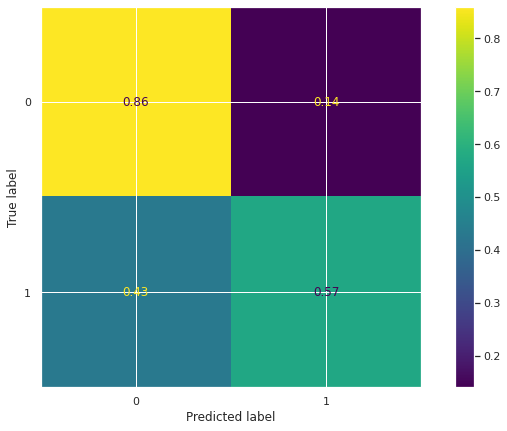

In [236]:
cm = confusion_matrix(y_test,y_pred,normalize='true', labels=clf.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## RandomizedSearchCV

Randomized search on hyper parameters.
Before performing the grid search we do a Randomized search on hyper parameters to get clues about the best grid search configuration.



We will train the "RandomForestClassifier" with the different options of the following three parameters:
- **criterion** (The function to measure the quality of a split):
    - gini
    - entropy
- **n_estimators** (The number of trees in the forest.)
    - range from 50 to 999
- **max_features** (The number of features to consider when looking for the best split):
    - auto
    - sqrt
    - log2
    - None

- **max_depth** (The maximum depth of the tree.)
    - range from 2 to 14
- **min_samples_split** (The minimum number of samples required to split an internal node)
    - range from 2 to 4
- **bootstrap** (Whether bootstrap samples are used when building trees):
    - True
    - False


In [237]:
random_forest_params = {'n_estimators': list(range(50, 1000)),
                      'criterion': ["gini", "entropy"],
                      'max_depth': list(range(2, 15)),
                      "min_samples_split": list(range(2, 5)),
                      "max_features": ["auto", "sqrt", "log2", None],
                      'bootstrap': [True, False]}

param_dist = { **random_forest_params}

Of all the possible combinations of parameters we will only train 100 randomly with 3 cross-validations each.

In [238]:
random_search = RandomizedSearchCV(clf,param_distributions=param_dist,n_iter=100, cv=3, random_state=130,  scoring="accuracy", verbose=1)

In [239]:
random_search.fit(X_train, y_train)

The best result is achieved with the following parameters.

In [240]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 157}

In [241]:
y_pred_RS = random_search.predict(X_test)

We get an accuracy of 0.77. We have improved by 0.02 the result of the classification with the default parameters.

In [242]:
print(classification_report(y_test, y_pred_RS))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       203
           1       0.78      0.54      0.64       125

    accuracy                           0.77       328
   macro avg       0.77      0.73      0.74       328
weighted avg       0.77      0.77      0.76       328



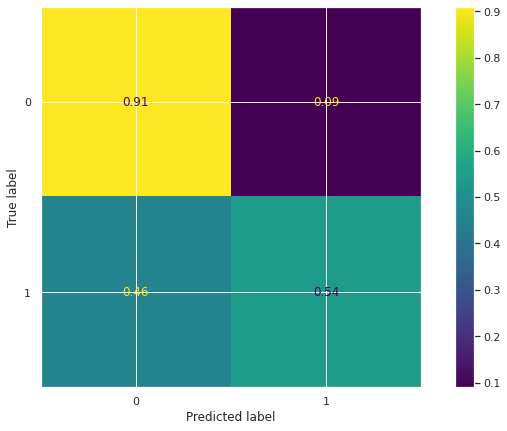

In [243]:
cm = confusion_matrix(y_test,y_pred_RS,normalize='true', labels=random_search.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

Tabulate random search results.

In [244]:
random_search_results = pd.DataFrame(random_search.cv_results_)
random_search_results = random_search_results.sort_values(by="rank_test_score")
random_search_results = random_search_results.filter(regex="mean_test_|param_")
random_search_results = random_search_results.rename(columns=lambda x: re.sub('mean_fit_|mean_test_|param_','',x))
random_search_results.rename({'score':'accuracy'}, axis=1, inplace=True)
random_search_results.fillna("None", inplace=True)
random_search_results.bootstrap = np.array(['No', 'Yes'])[random_search_results.bootstrap.astype(int)]
random_search_results.head()

,n_estimators,min_samples_split,max_features,max_depth,criterion,bootstrap,accuracy
56,157,3,auto,8,entropy,Yes,0.831804
48,472,2,auto,8,gini,Yes,0.827727
74,743,4,log2,6,entropy,Yes,0.827727
82,797,3,sqrt,8,gini,No,0.826707
49,815,2,sqrt,7,gini,Yes,0.825688


I do not see a clear relationship between the number of estimators and the accuracy achieved.

<AxesSubplot:xlabel='n_estimators', ylabel='accuracy'>

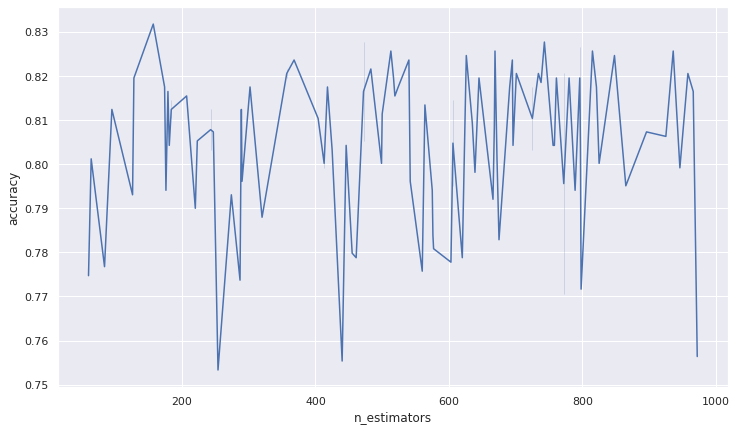

In [245]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="n_estimators")

Although the best result was achieved with min_samples_split = 3, it seems that from three min_samples_split and acuracy have a positive relationship.

<AxesSubplot:xlabel='min_samples_split', ylabel='accuracy'>

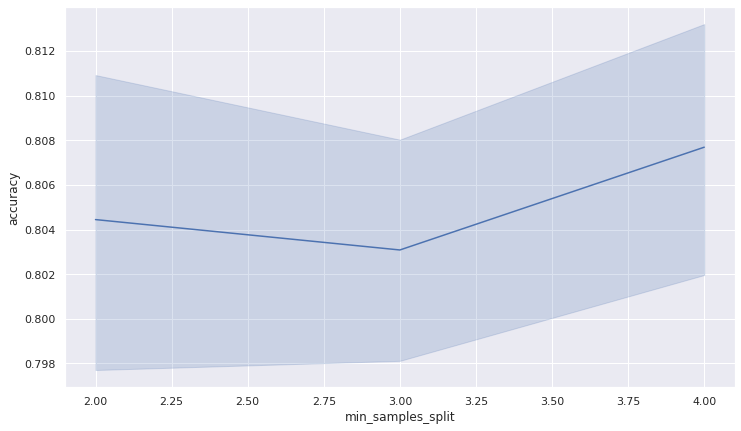

In [246]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="min_samples_split")

The best accuracy is obtained with max_features set to "auto" and "log2"

<AxesSubplot:xlabel='max_features', ylabel='accuracy'>

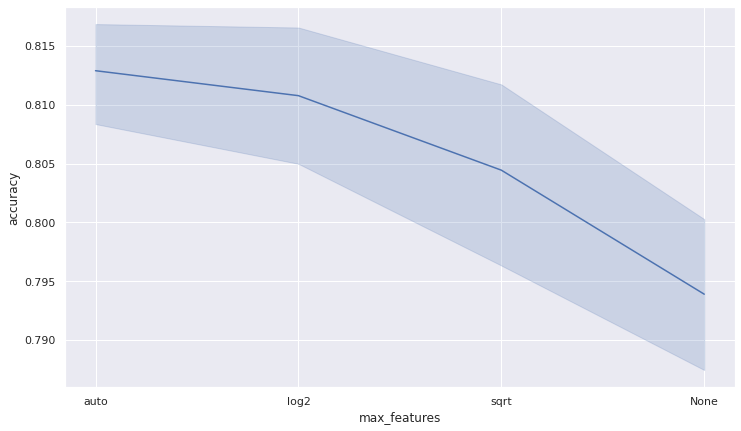

In [247]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="max_features")

The best precision is obtained with max_depth between 6 and 8

<AxesSubplot:xlabel='max_depth', ylabel='accuracy'>

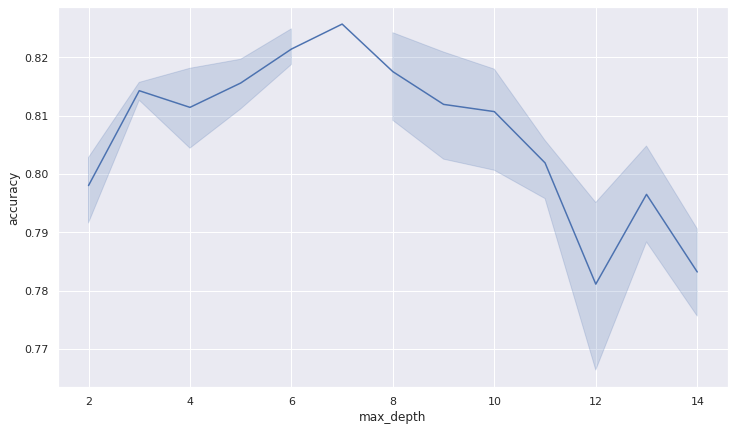

In [248]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="max_depth")

Bootstrapping is definitely the best option.

<AxesSubplot:xlabel='bootstrap', ylabel='accuracy'>

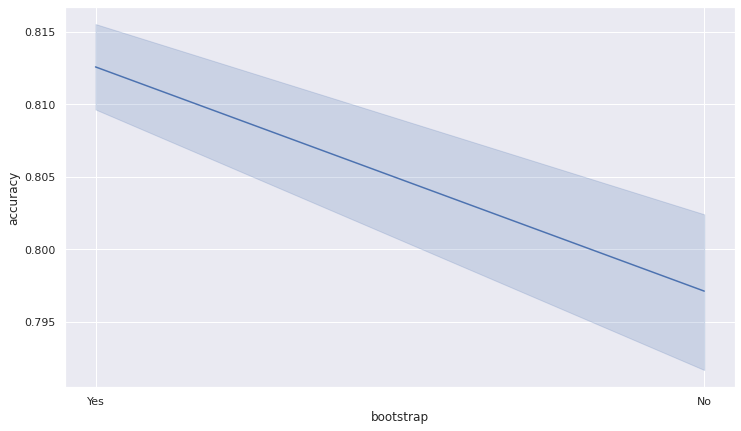

In [249]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="bootstrap")

Although the criterion shows a slight effect on the results, both will be used in the grid search.



<AxesSubplot:xlabel='criterion', ylabel='accuracy'>

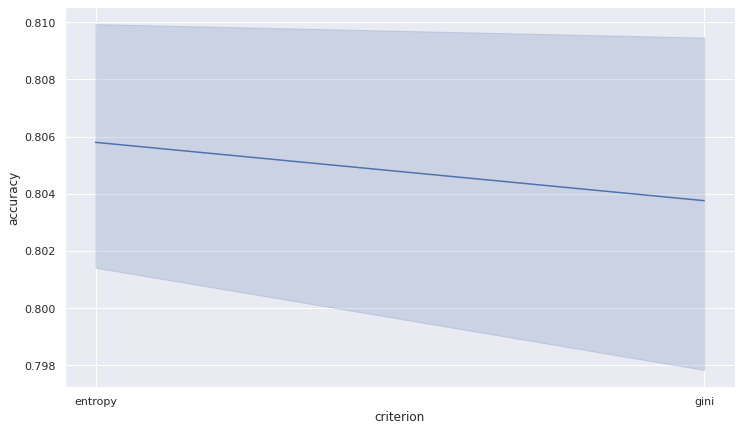

In [250]:
sns.lineplot(data=random_search_results, 
             y="accuracy",
             x="criterion")

## GridSearchCV

- In the grid search we will configure the "n_estimators" and the "max_depth" equal to those of the best 5 results obtained from ramdom search.
- In 'criterion' we will only use "gini", "entropy". 
- The "min_samples_split" will increase the search range from 3 to 6. 
- In 'max_features' we will only use "auto", "log2"". 
- And in all cases we will bootstrap.

In [251]:
param_grid = {'n_estimators': list(random_search_results.n_estimators[:5]),
                      'criterion': ["gini", "entropy"],
                      'max_depth': list(random_search_results.max_depth[:5].unique()),
                      "min_samples_split": list(range(3, 7)),
                      "max_features": ["auto", "log2"],
                      'bootstrap': [True]}



The 240 combinations of parameters will be train with 3 cross-validations each.

In [252]:
grid_search = GridSearchCV(clf, param_grid, cv=3,  scoring="accuracy", verbose=1)

In [253]:
grid_search.fit(X_train, y_train)

In [254]:
grid_search.best_score_

0.8318042813455658

In [255]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 6,
 'n_estimators': 157}

In [256]:
y_pred_GS = grid_search.predict(X_test)

In the grid search we have obtained the same results as in the random search.

In [257]:
print(classification_report(y_test, y_pred_GS))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       203
           1       0.78      0.54      0.64       125

    accuracy                           0.77       328
   macro avg       0.77      0.72      0.73       328
weighted avg       0.77      0.77      0.75       328



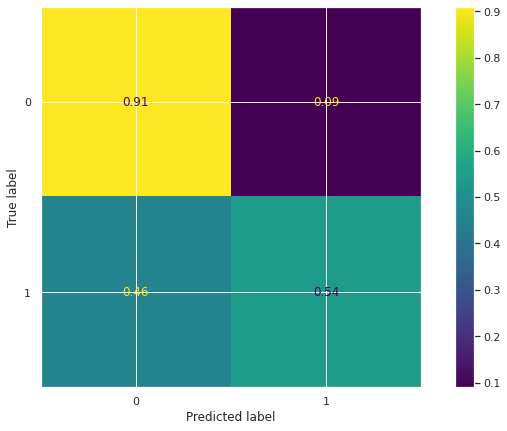

In [258]:
cm = confusion_matrix(y_test,y_pred_GS,normalize='true', labels=random_search.classes_).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

# Exercise 2:
Use a text in English that you want and calculate the frequency of the words

I will use the [Full Transcript: Trump’s 2020 State of the Union Address](https://www.nytimes.com/2020/02/05/us/politics/state-of-union-transcript.html)

We get the webpage

In [259]:
URL = "https://www.nytimes.com/2020/02/05/us/politics/state-of-union-transcript.html"
page = requests.get(URL)
print(page)

<Response [200]>


We parse the page content with beautifulSoup

In [260]:
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

<!DOCTYPE html>
<html class="story nytapp-vi-article" lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <meta charset="utf-8"/>
  <title data-rh="true">
   Full Transcript of Trump's State of The Union Address - The New York Times
  </title>
  <meta content="noarchive, max-image-preview:large" data-rh="true" name="robots"/>
  <meta content="President Trump spoke of a “great American comeback” in his third State of the Union address." data-rh="true" name="description"/>
  <meta content="https://www.nytimes.com/2020/02/05/us/politics/state-of-union-transcript.html" data-rh="true" property="og:url"/>
  <meta content="article" data-rh="true" property="og:type"/>
  <meta content="Full Transcript: Trump’s 2020 State of the Union Address (Published 2020)" data-rh="true" property="og:title"/>
  <meta content="https://static01.nyt.com/images/2020/02/04/us/politics/04dc-video-live/04dc-video-live-facebookJumbo-v2.jpg?year=2020&amp;h=550&amp;w=1050&amp;s=b71ef6c1cbfe82c91b5f

We select all the `<p>` tags which represent paragraphs.

In [261]:
p_tags = soup.find_all("p")

We see that the speech starts from paragraph 5

In [262]:
p_tags[:7]

[<p>Advertisement</p>,
 <p>Supported by</p>,
 <p class="css-w6ymp8 e1wiw3jv0" id="article-summary">President Trump spoke of a “great American comeback” in his third State of the Union address.</p>,
 <p class="css-axufdj evys1bk0"><em class="css-2fg4z9 e1gzwzxm0">President Trump delivered his third </em><a class="css-1g7m0tk" href="https://www.nytimes.com/2020/02/05/podcasts/the-daily/state-of-the-union.html" title=""><em class="css-2fg4z9 e1gzwzxm0">State of the Union</em></a><em class="css-2fg4z9 e1gzwzxm0"> address on Tuesday to a joint session of Congress. The speech came a day before the Senate was scheduled to cast its final votes in the impeachment trial, determining whether to remove Mr. Trump from office.</em></p>,
 <p class="css-axufdj evys1bk0"><em class="css-2fg4z9 e1gzwzxm0">The following is a transcript of his remarks, as released by The White House.</em></p>,
 <p class="css-axufdj evys1bk0">PRESIDENT TRUMP: Thank you very much. Thank you. Thank you very much.</p>,
 <p cla

We see that the speech ends in the penultimate paragraph.

In [263]:
p_tags[-5:]

[<p class="css-axufdj evys1bk0">America is the place where anything can happen. America is the place where anyone can rise. And here, on this land, on this soil, on this continent, the most incredible dreams come true.</p>,
 <p class="css-axufdj evys1bk0">This nation is our canvas, and this country is our masterpiece. We look at tomorrow and see unlimited frontiers just waiting to be explored. Our brightest discoveries are not yet known. Our most thrilling stories are not yet told. Our grandest journeys are not yet made. The American Age, the American Epic, the American adventure has only just begun.</p>,
 <p class="css-axufdj evys1bk0">Our spirit is still young, the sun is still rising, God’s grace is still shining, and, my fellow Americans, the best is yet to come. (Applause.)</p>,
 <p class="css-axufdj evys1bk0">Thank you. God bless you. And God bless America. Thank you very much. (Applause.)</p>,
 <p>Advertisement</p>]

We see that some paragraphs refer to the audience

In [264]:
p_tags[61:64]

[<p class="css-axufdj evys1bk0">But as we work to improve Americans’ health care, there are those who want to take away your health care, take away your doctor, and abolish private insurance entirely.</p>,
 <p class="css-axufdj evys1bk0">AUDIENCE: Booo —</p>,
 <p class="css-axufdj evys1bk0">THE PRESIDENT: One hundred thirty-two lawmakers in this room have endorsed legislation to impose a socialist takeover of our health care system, wiping out the private health insurance plans of 180 million very happy Americans. To those watching at home tonight, I want you to know: We will never let socialism destroy American health care. (Applause.)</p>]

We select only the paragraphs of interest.

In [265]:
paragraphs=[]
for p_tag in p_tags[5:-1]:
    s = p_tag.string
    if not s.startswith("AUDIENCE"):
        paragraphs.append(s)

In [266]:
paragraphs[:7]

['PRESIDENT TRUMP: Thank you very much. Thank you. Thank you very much.',
 'Madam Speaker, Mr. Vice President, members of Congress, the first lady of the United States — (applause) — and my fellow citizens:',
 'Three years ago, we launched the great American comeback. Tonight, I stand before you to share the incredible results. Jobs are booming, incomes are soaring, poverty is plummeting, crime is falling, confidence is surging, and our country is thriving and highly respected again. (Applause.) America’s enemies are on the run, America’s fortunes are on the rise, and America’s future is blazing bright.',
 'The years of economic decay are over. (Applause.) The days of our country being used, taken advantage of, and even scorned by other nations are long behind us. (Applause.) Gone, too, are the broken promises, jobless recoveries, tired platitudes and constant excuses for the depletion of American wealth, power and prestige.',
 'In just three short years, we have shattered the mentalit

We tabulate the text, where each paragraph is a record.

In [267]:
df = pd.DataFrame(paragraphs)
df.columns= ["paragraphs"]
df.head(3)

,paragraphs
0,PRESIDENT TRUMP: Thank you very much. Thank yo...
1,"Madam Speaker, Mr. Vice President, members of ..."
2,"Three years ago, we launched the great America..."


## Frequency of the words

We apply to each paragraph the function `paragraph_to_words()` with which we remove non-letters characters, convert to lowercase and finally perform word tokenizer. 


In [268]:
df['words']=df['paragraphs'].apply(lambda paragraph: paragraph_to_words(paragraph))

In [269]:
df.head(3)

,paragraphs,words
0,PRESIDENT TRUMP: Thank you very much. Thank yo...,"[president, trump, thank, you, very, much, tha..."
1,"Madam Speaker, Mr. Vice President, members of ...","[madam, speaker, mr, vice, president, members,..."
2,"Three years ago, we launched the great America...","[three, years, ago, we, launched, the, great, ..."


We create a list with all the words and count the number of times that each word occurs.

In [270]:
words_list=[]
for wordslist in df.words:
    words_list.extend(wordslist)

words_fdist = FreqDist(words_list)

The 20 most frequent words

In [271]:
words_fdist.most_common(20)

[('the', 291),
 ('and', 223),
 ('to', 166),
 ('of', 150),
 ('applause', 132),
 ('in', 114),
 ('is', 101),
 ('a', 101),
 ('we', 98),
 ('our', 95),
 ('that', 74),
 ('s', 73),
 ('you', 71),
 ('are', 64),
 ('for', 63),
 ('i', 60),
 ('have', 51),
 ('on', 40),
 ('with', 40),
 ('america', 38)]

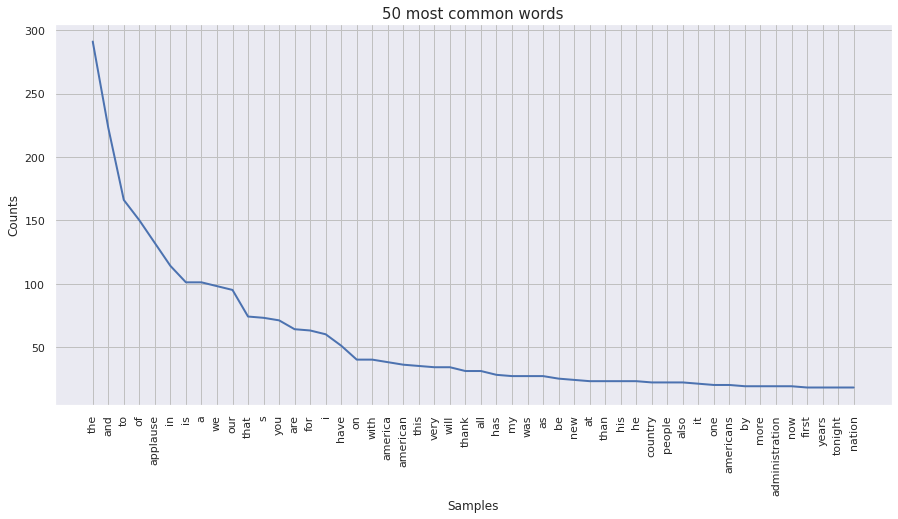

In [272]:
# Frequency Distribution Plot
plt.figure(figsize = (15, 7))
plt.title('50 most common words', fontsize=15)
words_fdist.plot(50, cumulative=False)
plt.show()

Plotting wordCloud with 100 most common words

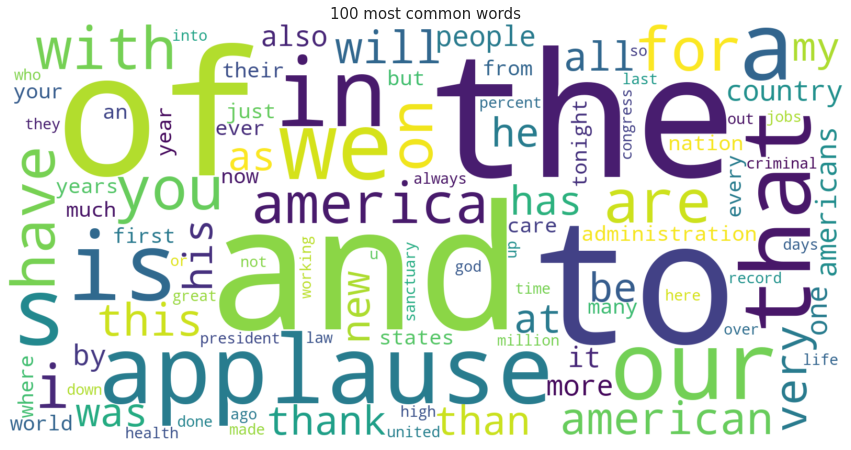

In [273]:

wc = WordCloud(max_words = 100, width = 1600, height = 800, background_color ='white',repeat=True)
wc.fit_words(words_fdist)
plt.figure(figsize = (15, 15), facecolor = None)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.title('100 most common words', fontsize=15)
plt.show()

# Exercise 3: 
Remove stopwords and stemming your dataset.

## Stopwords

We apply to each list of words the function `remove_stopwords()` with which we remove the standard stopwords plus '**laughter**', '**applause**' and '**from**'. 

In [281]:
df['cln_words']=df['words'].apply(lambda words: remove_stopwords(words))

In [282]:
df.head(3)

,paragraphs,words,cln_words
0,PRESIDENT TRUMP: Thank you very much. Thank yo...,"[president, trump, thank, you, very, much, tha...","[president, trump, thank, much, thank, thank, ..."
1,"Madam Speaker, Mr. Vice President, members of ...","[madam, speaker, mr, vice, president, members,...","[madam, speaker, mr, vice, president, members,..."
2,"Three years ago, we launched the great America...","[three, years, ago, we, launched, the, great, ...","[three, years, ago, launched, great, american,..."


List of non stopwords and count.

In [283]:
cln_words_list=[]
for wordslist in df.cln_words:
    cln_words_list.extend(wordslist)

cln_words_fdist = FreqDist(cln_words_list)

In [284]:
cln_words_fdist.most_common(20)

[('america', 38),
 ('american', 36),
 ('thank', 31),
 ('new', 24),
 ('country', 22),
 ('people', 22),
 ('also', 22),
 ('one', 20),
 ('americans', 20),
 ('administration', 19),
 ('first', 18),
 ('years', 18),
 ('tonight', 18),
 ('nation', 18),
 ('world', 17),
 ('much', 16),
 ('states', 16),
 ('every', 16),
 ('year', 16),
 ('many', 16)]

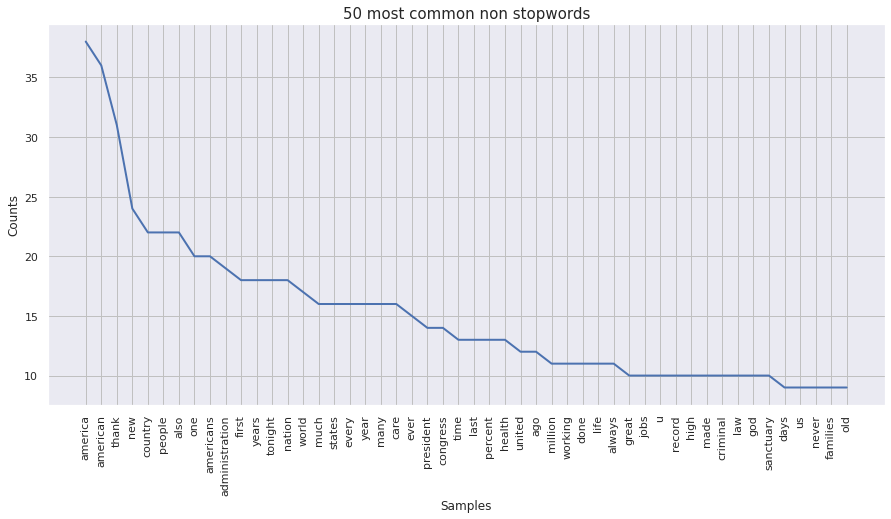

In [285]:
plt.figure(figsize = (15, 7))
plt.title('50 most common non stopwords', fontsize=15)
cln_words_fdist.plot(50, cumulative=False)
plt.show()

Plotting wordCloud

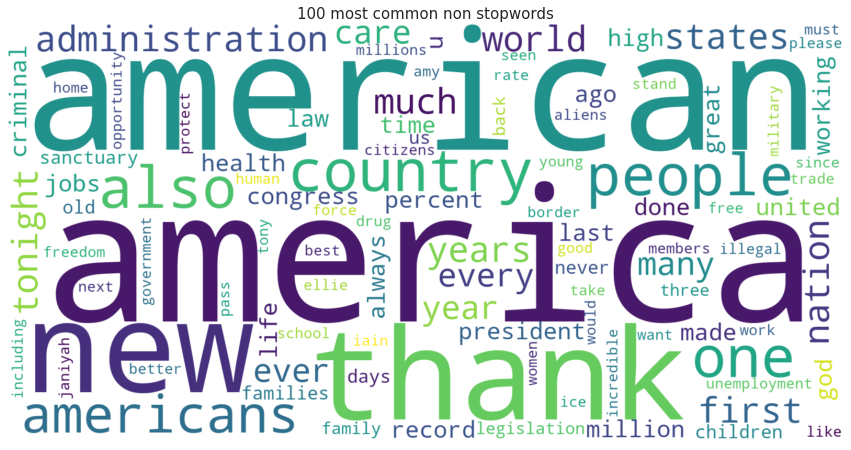

In [286]:
wc = WordCloud(max_words = 100, width = 1600, height = 800, background_color ='white',repeat=True)
wc.fit_words(cln_words_fdist)
plt.figure(figsize = (15, 15), facecolor = None)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.title('100 most common non stopwords', fontsize=15)
plt.show()

## Stemming

We apply to each list of non stopwords the function `words_to_stem()` with which we obtein the stem from each word.

In [287]:
df['stem_words']=df['cln_words'].apply(lambda words: words_to_stem(words))

In [288]:
df.head(3)

,paragraphs,words,cln_words,stem_words
0,PRESIDENT TRUMP: Thank you very much. Thank yo...,"[president, trump, thank, you, very, much, tha...","[president, trump, thank, much, thank, thank, ...","[presid, trump, thank, much, thank, thank, much]"
1,"Madam Speaker, Mr. Vice President, members of ...","[madam, speaker, mr, vice, president, members,...","[madam, speaker, mr, vice, president, members,...","[madam, speaker, mr, vice, presid, member, con..."
2,"Three years ago, we launched the great America...","[three, years, ago, we, launched, the, great, ...","[three, years, ago, launched, great, american,...","[three, year, ago, launch, great, american, co..."


List of stem words and count.

In [289]:
stem_words_list=[]
for wordslist in df.stem_words:
    stem_words_list.extend(wordslist)

stem_words_fdist = FreqDist(stem_words_list)

In [290]:
stem_words_fdist.most_common(20)

[('american', 56),
 ('america', 38),
 ('thank', 36),
 ('year', 34),
 ('new', 24),
 ('countri', 22),
 ('nation', 22),
 ('peopl', 22),
 ('also', 22),
 ('work', 21),
 ('one', 20),
 ('administr', 20),
 ('state', 19),
 ('first', 18),
 ('tonight', 18),
 ('world', 17),
 ('famili', 17),
 ('million', 17),
 ('care', 17),
 ('much', 16)]

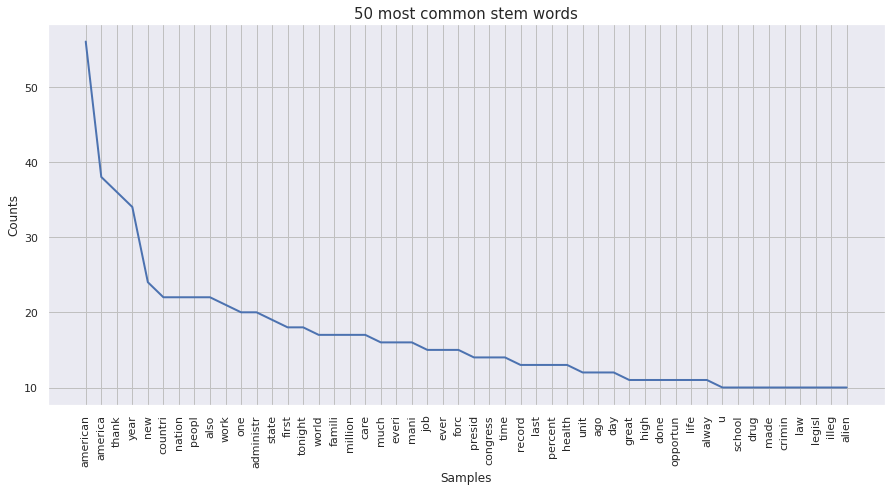

In [291]:
# Frequency Distribution Plot
plt.figure(figsize = (15, 7))
plt.title('50 most common stem words', fontsize=15)
stem_words_fdist.plot(50, cumulative=False)
plt.show()

Plotting wordCloud

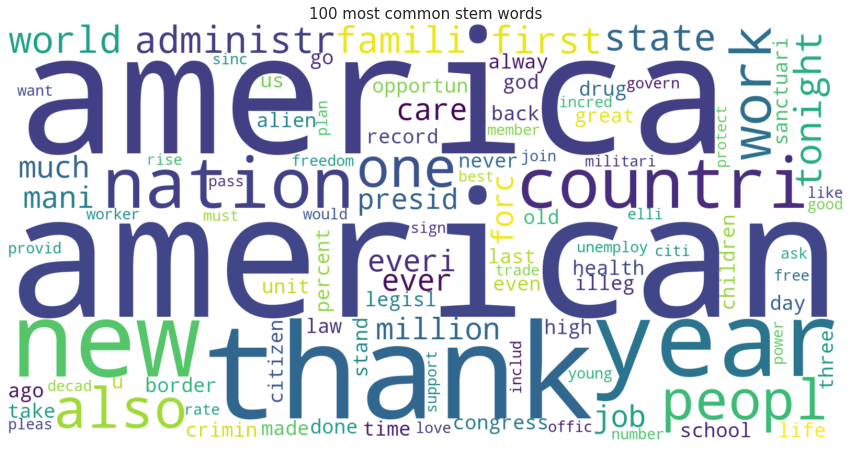

In [292]:

wc = WordCloud(max_words = 100, width = 1600, height = 800, background_color ='white',repeat=True)
wc.fit_words(stem_words_fdist)
plt.figure(figsize = (15, 15), facecolor = None)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.title('100 most common stem words', fontsize=15)
plt.show()

# Exercise 4: 
Perform sentiment analysis on your dataset.

## Sentiment analysis

We obtain a sentiment intensity score of each paragraph.

In [293]:
s_analyzer=SentimentIntensityAnalyzer()
sentiments=df['paragraphs'].apply(lambda x: s_analyzer.polarity_scores(x))
df['compound']=sentiments.apply(lambda x : x['compound'])
df['negative']=sentiments.apply(lambda x : x['neg'])
df['neutral']=sentiments.apply(lambda x : x['neu'])
df['positive']=sentiments.apply(lambda x : x['pos'])

In [294]:
df.head(3)

,paragraphs,words,cln_words,stem_words,compound,negative,neutral,positive
0,PRESIDENT TRUMP: Thank you very much. Thank yo...,"[president, trump, thank, you, very, much, tha...","[president, trump, thank, much, thank, thank, ...","[presid, trump, thank, much, thank, thank, much]",0.7579,0.000,0.545,0.455
1,"Madam Speaker, Mr. Vice President, members of ...","[madam, speaker, mr, vice, president, members,...","[madam, speaker, mr, vice, president, members,...","[madam, speaker, mr, vice, presid, member, con...",0.4215,0.000,0.872,0.128
2,"Three years ago, we launched the great America...","[three, years, ago, we, launched, the, great, ...","[three, years, ago, launched, great, american,...","[three, year, ago, launch, great, american, co...",0.6997,0.145,0.638,0.217


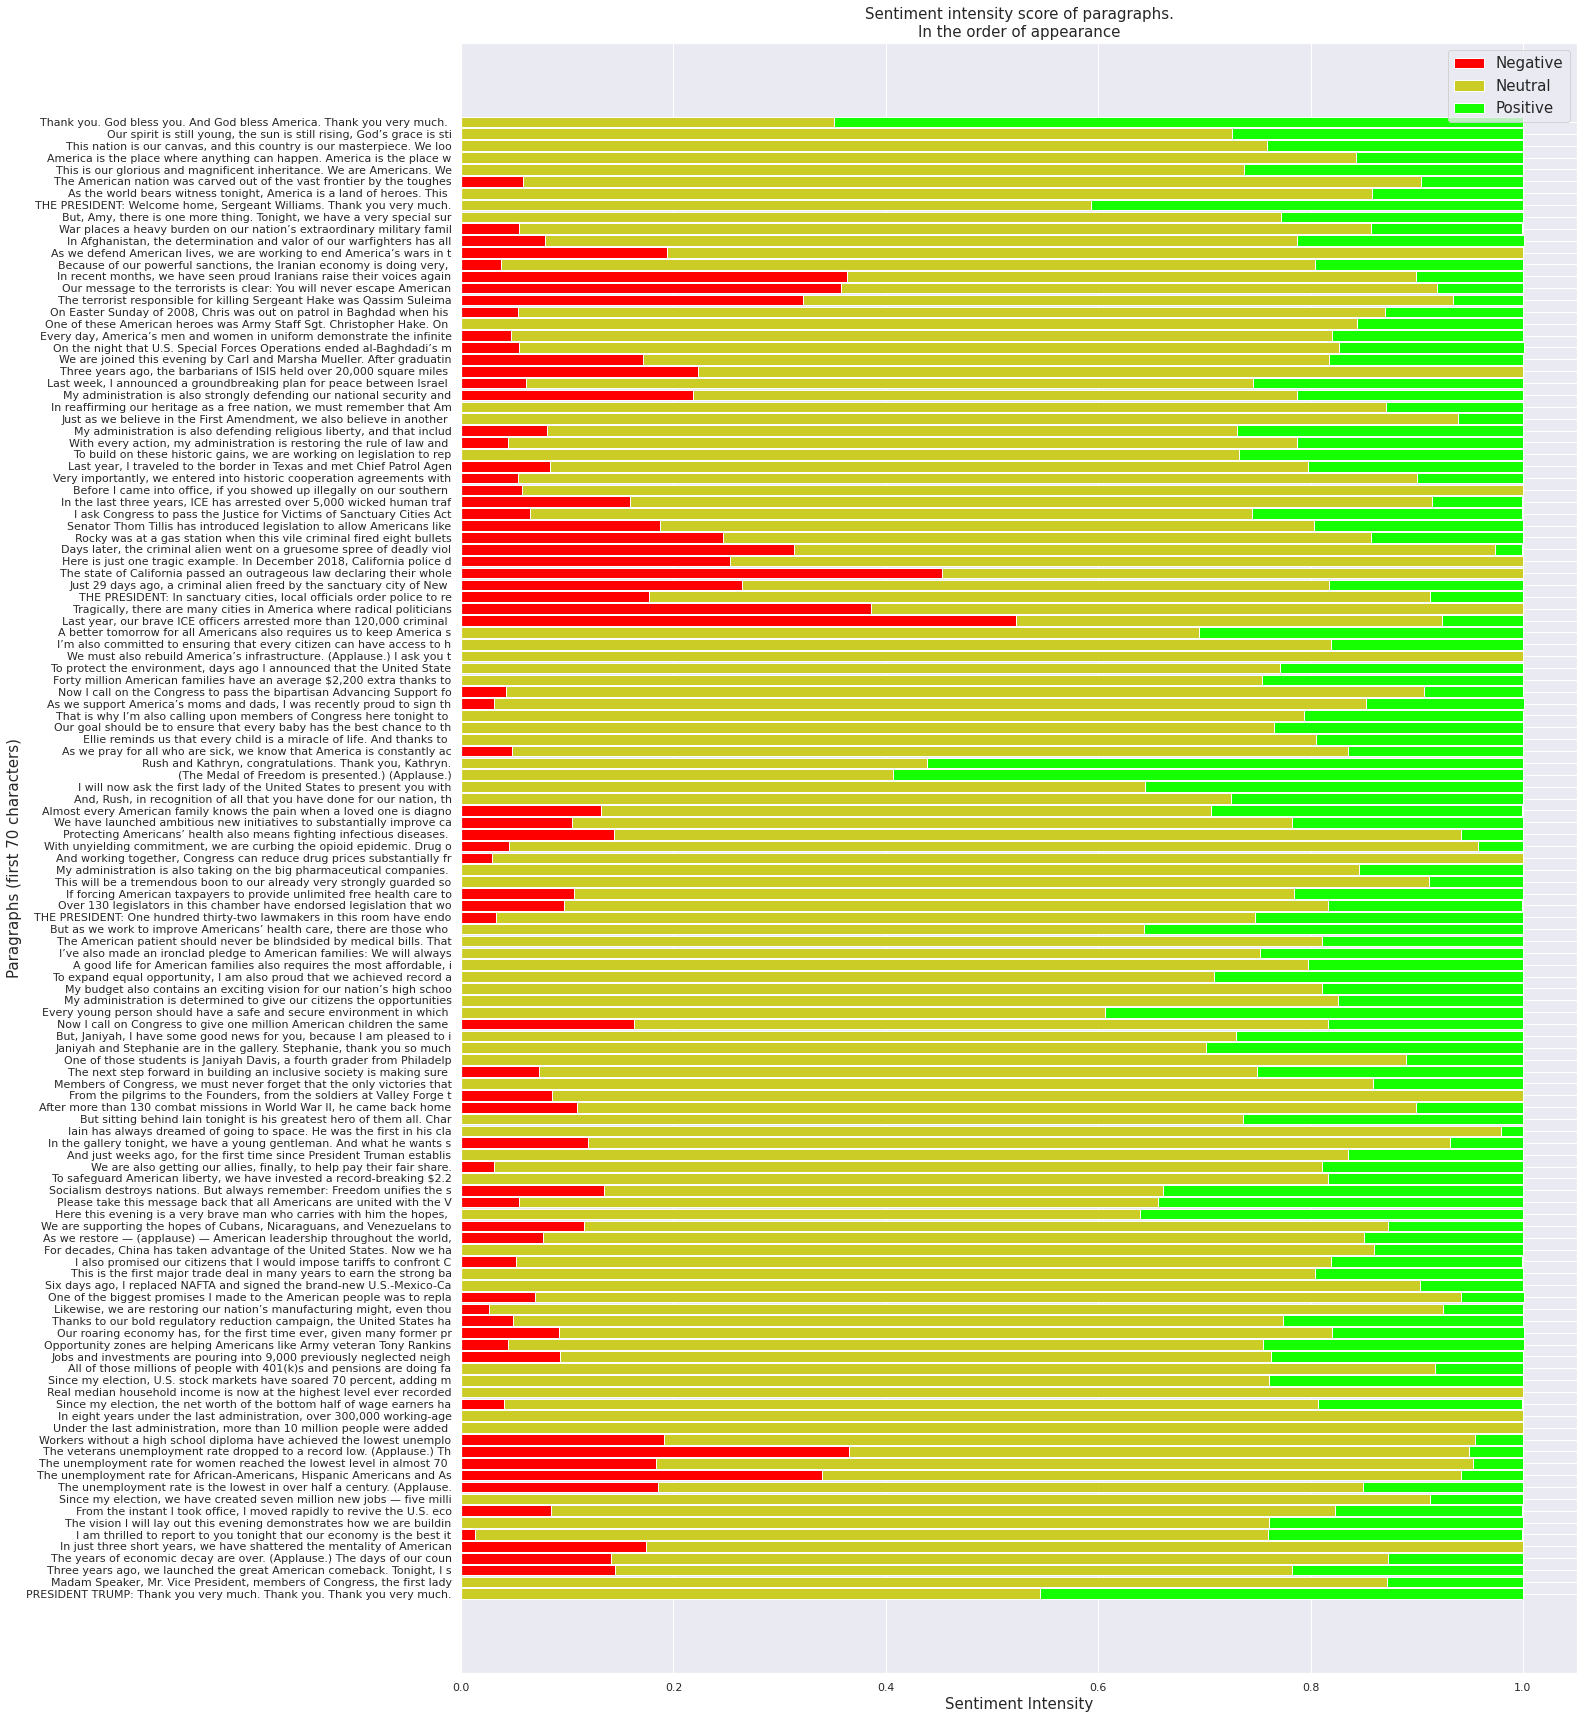

In [295]:
plt.figure(figsize=(20,30))
names = df['paragraphs'].str[:70]
barWidth = 0.9

# Create negative Bars
plt.barh(y=names, 
        width=df.negative, 
        height=barWidth, color='#ff0000', label='Negative')
# Create neutral Bars
plt.barh(y=names, 
        width=df.neutral,
        height=barWidth,  left=df.negative,  color='#cccc27', label='Neutral')
# Create positive Bars
plt.barh(y=names, 
        width=df.positive, 
        height=barWidth,  left=[i+j for i,j in zip(df.negative, df.neutral)],color='#15ff00', label='Positive')
 
plt.yticks(names)
plt.ylabel("Paragraphs (first 70 characters)", fontsize=15)
plt.xlabel("Sentiment Intensity", fontsize=15)
plt.legend(fontsize=15) 
plt.title("Sentiment intensity score of paragraphs.\nIn the order of appearance", fontsize=15)
plt.show()

We can see that the speech both begins and ends with paragraphs completely devoid of negative sentiments.

On average, the speech has more positive than negative sentiments.

In [296]:
df[["negative","positive"]].describe()

,negative,positive
count,125.000000,125.000000
mean,0.077680,0.175288
std,0.109529,0.120754
min,0.000000,0.000000
25%,0.000000,0.087000
50%,0.040000,0.180000
75%,0.109000,0.239000
max,0.523000,0.649000


Find and create list of all negative words in speeches

In [297]:
negative_words=[]
for word in cln_words_list:
    if s_analyzer.polarity_scores(word)['compound']<0:
        negative_words.append(word)
        
neg_words_fdist=FreqDist(negative_words)
neg_words_fdist.most_common(20)

[('criminal', 10),
 ('unemployment', 8),
 ('illegal', 8),
 ('lowest', 5),
 ('arrested', 5),
 ('low', 4),
 ('assault', 4),
 ('poverty', 3),
 ('rejected', 3),
 ('fighting', 3),
 ('struggling', 3),
 ('failing', 3),
 ('war', 3),
 ('terrible', 3),
 ('victims', 3),
 ('suffering', 3),
 ('falling', 2),
 ('broken', 2),
 ('killing', 2),
 ('cuts', 2)]

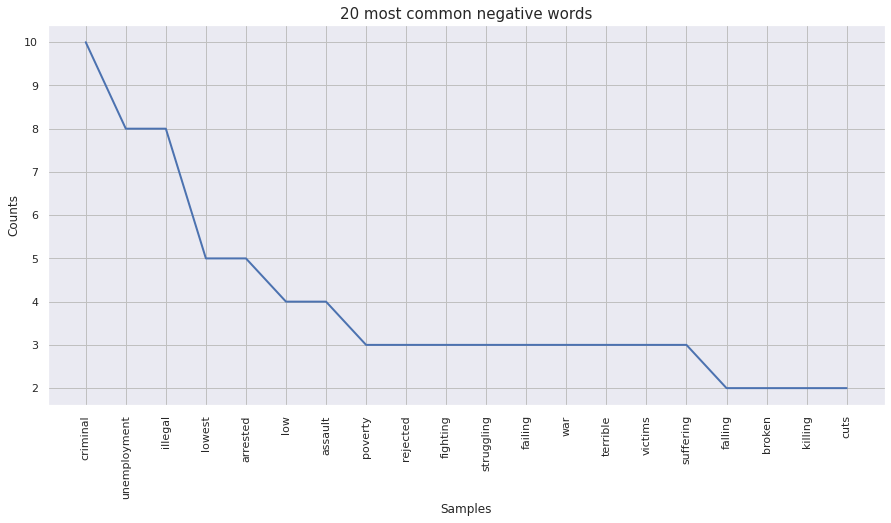

In [298]:
plt.figure(figsize = (15, 7))
plt.title('20 most common negative words', fontsize=15)
neg_words_fdist.plot(20, cumulative=False)
plt.show()

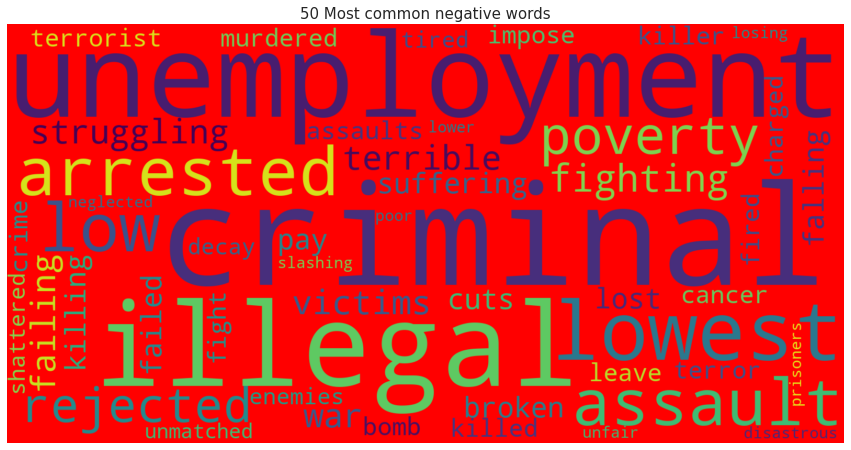

In [299]:
wc1 = WordCloud(max_words = 50, width = 1600, height = 800, background_color ='red',repeat=True)
wc1.fit_words(neg_words_fdist)

plt.figure(figsize = (15, 10), facecolor = None)
plt.axis("off")
plt.imshow(wc1, interpolation='bilinear')
plt.title('50 Most common negative words', fontsize=15)
plt.show()

Find and create list of all positive words in speeches

In [300]:
positive_words=[]
for word in cln_words_list:
    if s_analyzer.polarity_scores(word)['compound']>0:
        positive_words.append(word)
        
pos_words_fdist=FreqDist(positive_words)
pos_words_fdist.most_common(20)

[('thank', 31),
 ('care', 16),
 ('united', 12),
 ('great', 10),
 ('god', 10),
 ('opportunity', 8),
 ('free', 8),
 ('like', 7),
 ('freedom', 7),
 ('good', 7),
 ('best', 6),
 ('better', 6),
 ('protect', 6),
 ('want', 6),
 ('please', 6),
 ('number', 5),
 ('reached', 5),
 ('thanks', 5),
 ('justice', 5),
 ('love', 5)]

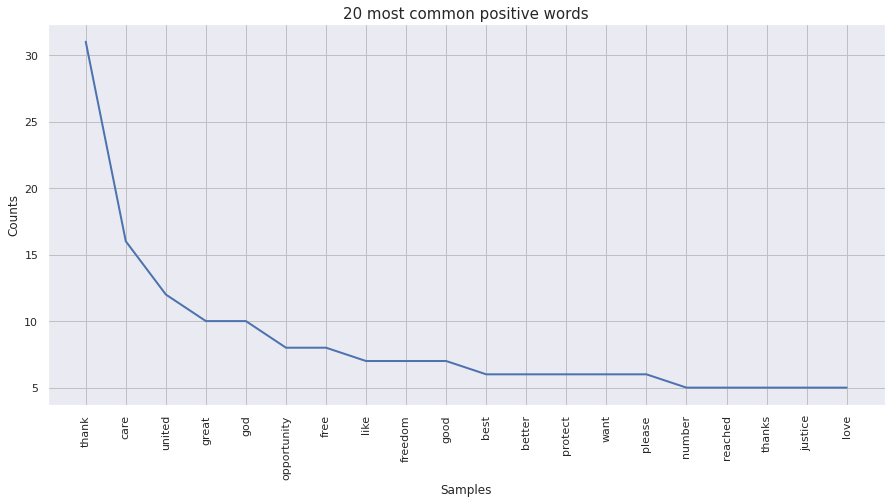

In [301]:
plt.figure(figsize = (15, 7))
plt.title('20 most common positive words', fontsize=15)
pos_words_fdist.plot(20, cumulative=False)
plt.show()

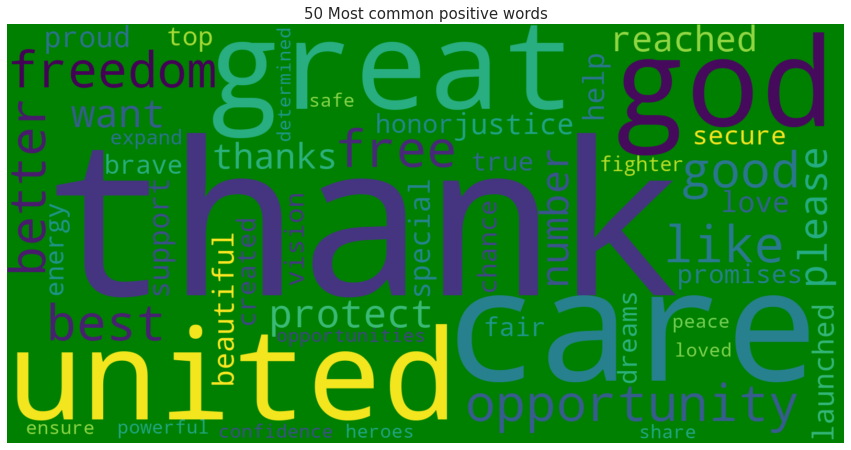

In [302]:
wc2 = WordCloud(max_words = 50, width = 1600, height = 800, background_color ='green',repeat=True)
wc2.fit_words(pos_words_fdist)

plt.figure(figsize = (15, 10), facecolor = None)
plt.axis("off")
plt.imshow(wc2, interpolation='bilinear')
plt.title('50 Most common positive words', fontsize=15)
plt.show()